In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob

In [2]:
GRID_H = 9
GRID_W = 6

In [3]:
with open("cameraCal.npy", "rb") as f:
    mtx = np.load(f)
    dist = np.load(f)

class undistort:
    def __init__(self, mtx, dist):
        self.mtx = mtx
        self.dist = dist

    def undistort(self, img):
        h,  w = img.shape[:2]
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(self.mtx, self.dist, (w,h), 1, (w,h))

        dst = cv2.undistort(img, self.mtx, self.dist, None, newcameramtx)

        return dst

UDT = undistort(mtx, dist)

In [4]:
def get_length(p1, p2):
    return np.sqrt( (p1[0]-p2[0]) ** 2 + (p1[1]-p2[1]) ** 2)

In [5]:
images = glob.glob('distance/*.jpg')
images.sort()

distance = 300 # mm
distance_increment = 100
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

FRST_P = 0
SCND_P = 8
LENGTH = 22 * (SCND_P - FRST_P + 1) # mm

lengths = []
distances = []

for fname in images:
    img = cv2.imread(fname)
    img = UDT.undistort(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (GRID_H,GRID_W), None)

    if ret:
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)

        length = get_length(corners2[FRST_P][0], corners2[SCND_P][0])

        lengths.append(length)
        distances.append(distance)

        distance += distance_increment


Text(0, 0.5, '1/Distance')

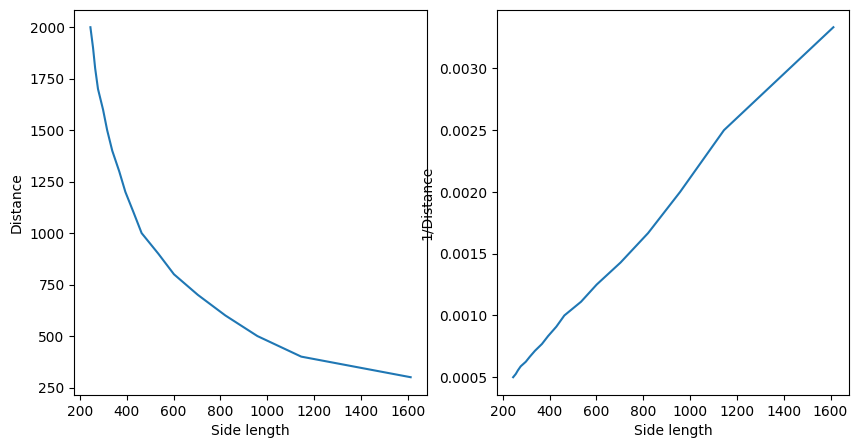

In [6]:
distances2 = [1/x for x in distances]

plt.figure(figsize=(10, 5))  # Set the figure size

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(lengths, distances)
plt.xlabel("Side length")
plt.ylabel("Distance")

plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot
plt.plot(lengths, distances2)
plt.xlabel("Side length")
plt.ylabel("1/Distance")


As expected from the perspective model, the correlation between length of one side and distance is linear

In [7]:
lengths[:5], distances[:5]

([1612.2361259157212,
  1144.8944342644158,
  957.4668542392604,
  820.712468367803,
  703.2219863462495],
 [300, 400, 500, 600, 700])

In [8]:
class DistanceEstimator:
    def __init__(self, lengths, inv_distances):
        self.m, self.b = np.polyfit(lengths, inv_distances, 1)
    
    def get_distance(self, length):
        return 1 / (self.m * length + self.b)

DE = DistanceEstimator(lengths, distances2)
DE.get_distance(lengths[0])

296.7160230567498

In [9]:
def put_text(img, text):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (2000, 500)
    fontScale = 10
    color = (255, 0, 0)
    thickness = 20
    img = cv2.putText(img, text, org, font, 
                    fontScale, color, thickness, cv2.LINE_AA)
    return img

In [12]:
imgs = []
estimated_distances = []

for fname in images:
    img = cv2.imread(fname)
    img = UDT.undistort(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (GRID_H,GRID_W), None)

    if ret:
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)

        length = get_length(corners2[FRST_P][0], corners2[SCND_P][0])
        distance = DE.get_distance(length)
        estimated_distances.append(distance)
        distance = int(distance*10)
        distance /= 10

        img = put_text(img, str(distance))
        imgs.append(img)


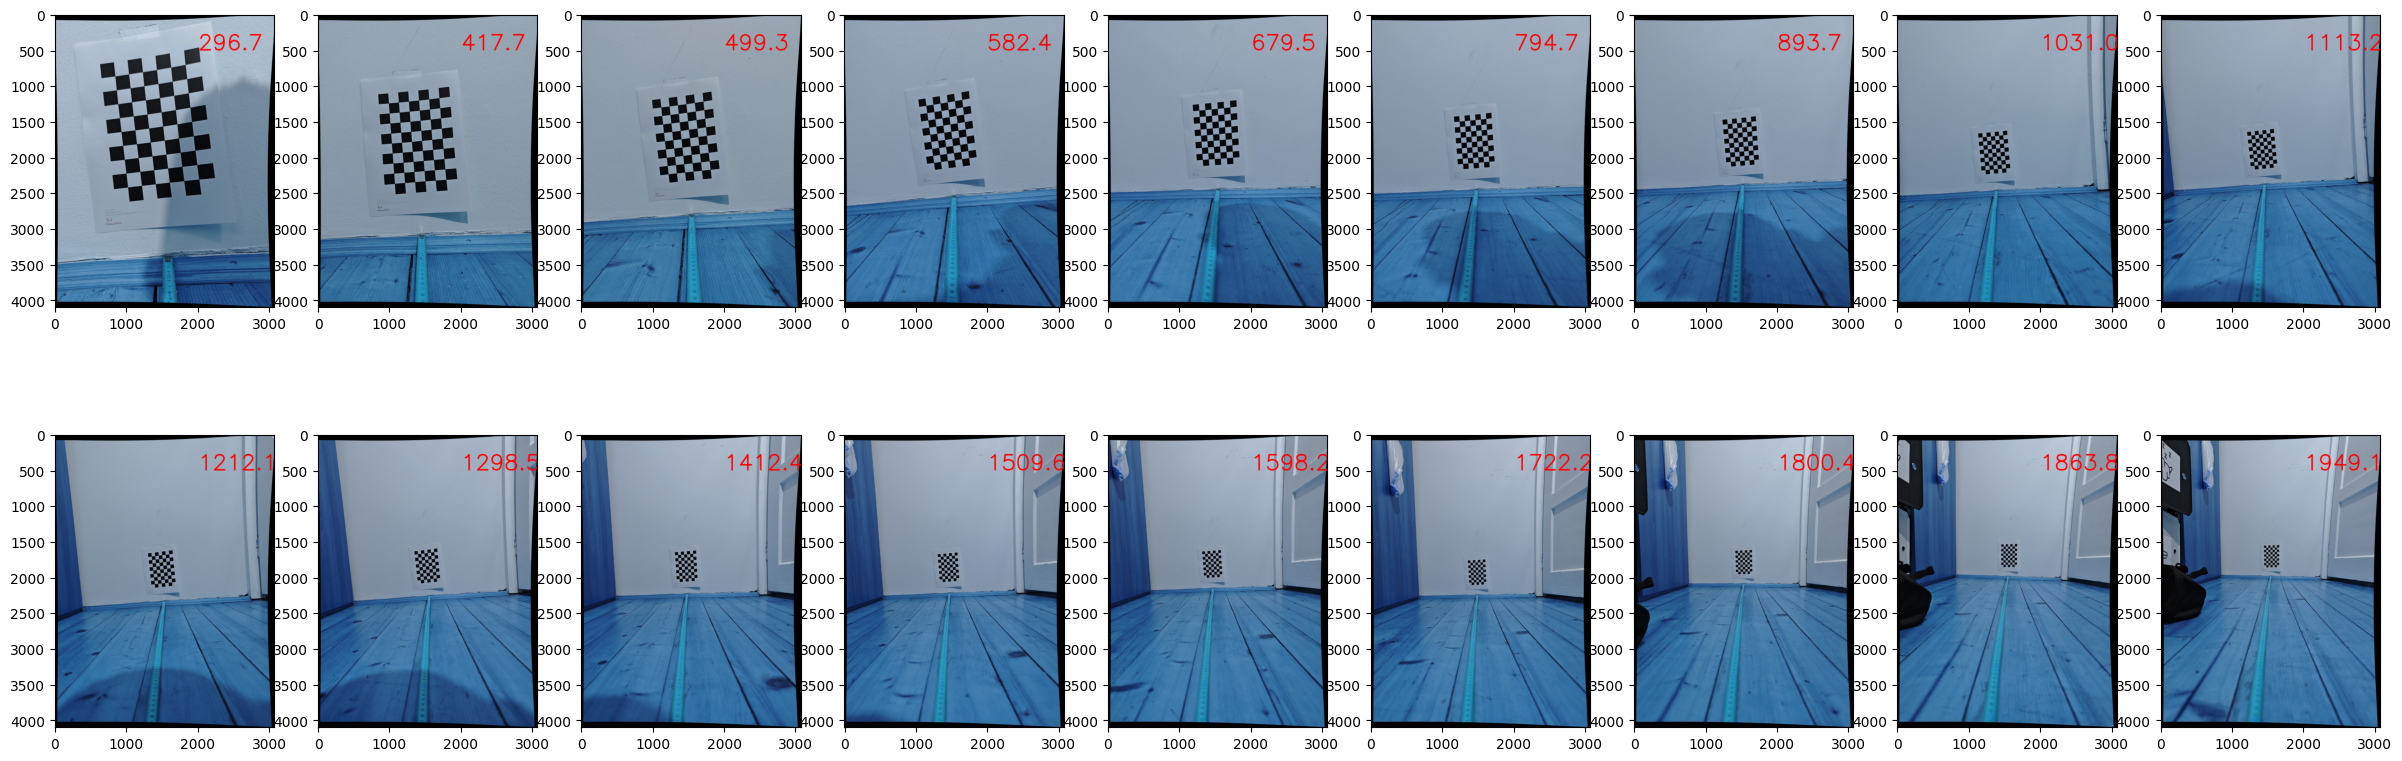

In [ ]:
plt.figure(figsize=(30, 10))  # Set the figure size
i = 1

for img in imgs:
    plt.subplot(2, 9, i)

    plt.imshow(img) #cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    i += 1

14.586523509107861


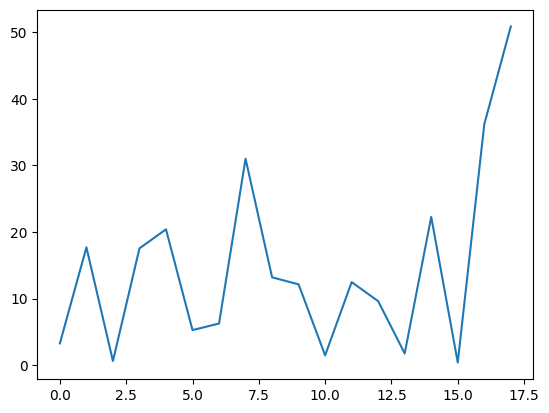

In [18]:
errors = []
distances_actual = []
distance = 300 # mm
distance_increment = 100
while distance < 2001:
    distances_actual.append(distance)
    distance += distance_increment

for i in range(len(distances)):
    error = abs(distances_actual[i] - estimated_distances[i])
    errors.append(error)

print(np.average(errors))
plt.plot(errors)